# **Import Statements**

In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils.experiment_manager import Experiment

%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

# **Data Reorganization** <br>


In [73]:
eye_bool = np.asarray([True, True, False, True, True, False, False, False])
electrode_list = ['u1', 'u2', 'u3', 'u4', 't2']
marker_list = ['u1', 'u2', 'u3', 'u4', 'u5']
filepath = 'eyeliddata.mat'

train = 0.7
val = 0.2
test = 0.1

reorganizer = Mat2TVT(eye_bool, electrode_list, marker_list, filepath)
_, _, identifier = reorganizer.load_data()
X, y = reorganizer.DMVC_norm()
TVT_dict = reorganizer.TVT_split(train, val, test)

# **Run Experiments**

In [82]:
params = {
    't_win': [0.2, 0.3],
    't_stride': [5, 10],
    't_lookahead': [50, 200],
    'p_transform': [0, 0.3],
    'sigma': [0.5, 0.7],
    'p_mask': [0.1, 0.2],
    'batch_size': [32, 64],
    'learning_rate': [0.1, 0.01],
    'dropout': [0.2, 0.4],
}

experiment = Experiment()
best_params = experiment(params, TVT_dict, epochs = 2)


print(f"Best window size: {best_params['t_win']}, Best stride size: {best_params['t_stride']}, Best lookahead time: {best_params['t_lookahead']}")
print(f"Best transform probability: {best_params['p_transform']}, Best Jitter sigma: {best_params['sigma']}, Best mask length: {best_params['p_mask']}")
print(f"Best batch size: {best_params['batch_size']}, Best learning rate: {best_params['learning_rate']}, Best dropout probability: {best_params['dropout']}")


************************************************************
Running Experiment 0 of 512
************************************************************
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 7221.7%, Avg Marker Error: 163.8%, Avg loss: 1.247648 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 7147.3%, Avg Marker Error: 163.1%, Avg loss: 1.261472 

Done!
************************************************************
Running Experiment 1 of 512
************************************************************
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 5525.4%, Avg Marker Error: 125.0%, Avg loss: 1.222558 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 5471.9%, Avg Marker Error: 129.0%, Avg loss: 1.536134 

Done!
************************************************************
Running Experiment 2 of 512
************************************************************
Ep

ValueError: high <= 0

# **Plotting Loss Metrics**

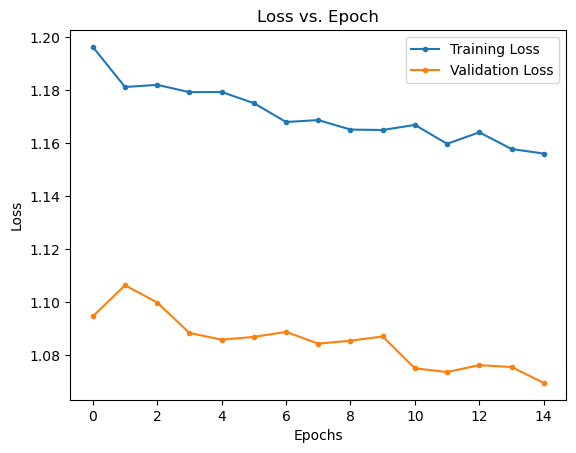

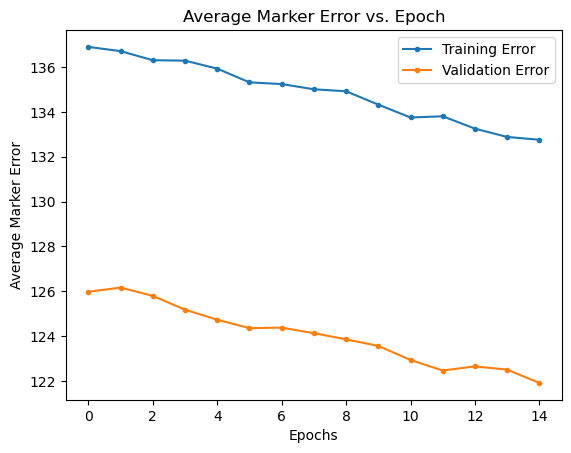

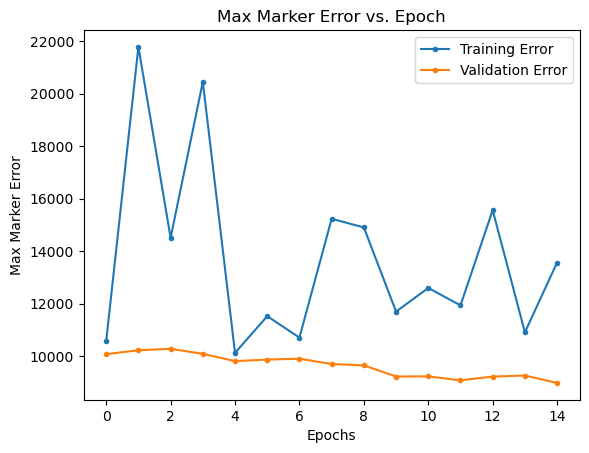

In [52]:
plt.plot(metrics['Training Loss'], label = 'Training Loss', marker = '.')
plt.plot(metrics['Validation Loss'], label = 'Validation Loss', marker = '.')
plt.title('Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['Training Avg Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Avg Marker Error'], label = 'Validation Error', marker = '.')
plt.title('Average Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Marker Error')
plt.legend()
plt.show()

plt.plot(metrics['Training Max Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Max Marker Error'], label = 'Validation Error', marker = '.')
plt.title('Max Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Max Marker Error')
plt.legend()
plt.show()